In [3]:
pip install lightgbm

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from lightgbm import LGBMClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Load data
df = pd.read_csv('../data/tourism_anomaly_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nAnomaly types: {df['anomaly_type'].unique()}")
print(f"\nAnomaly distribution:\n{df['anomaly_type'].value_counts()}")
df.head()


Dataset shape: (5000, 13)

Anomaly types: [nan 'Dropoff' 'OffRoute' 'Inactive' 'Distress']

Anomaly distribution:
anomaly_type
Dropoff     277
Distress    262
OffRoute    259
Inactive    233
Name: count, dtype: int64


,timestamp,user_id,latitude,longitude,speed_mps,planned_route_id,distance_from_route_m,is_checkin,battery_percent,signal_strength,is_emergency_action,inactivity_minutes,anomaly_type
0,2025-01-01T08:00:00,user_35,26.959140,92.050022,1.050059,R1,11.160537,0,83,5,0,5,NaN
1,2025-01-01T08:01:00,user_46,26.885739,92.063565,0.687390,NaN,11.633045,0,75,3,0,4,NaN
2,2025-01-01T08:02:00,user_10,26.330661,93.178531,2.118861,R2,0.324938,1,61,4,0,1,NaN
3,2025-01-01T08:03:00,user_47,27.435820,92.673189,0.685492,NaN,4.835819,1,91,3,0,2,NaN
4,2025-01-01T08:04:00,user_46,26.804342,93.946232,1.257069,R1,27.602032,1,76,3,0,5,NaN


In [6]:
# Feature engineering: extract hour from timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Encode categorical variables
le_user = LabelEncoder()
le_route = LabelEncoder()
df['user_id_encoded'] = le_user.fit_transform(df['user_id'].astype(str))
df['planned_route_id'] = df['planned_route_id'].astype(str).fillna('None')
df['route_id_encoded'] = le_route.fit_transform(df['planned_route_id'])

# Encode boolean flags
for col in ['is_checkin', 'is_emergency_action']:
    df[col] = df[col].astype(int)

# Prepare target variable (None = 0, anomalies = 1)
df['is_anomaly'] = (df['anomaly_type'].notna()).astype(int)
df['anomaly_type_encoded'] = LabelEncoder().fit_transform(df['anomaly_type'].fillna('None'))

print(f"Anomaly rate: {df['is_anomaly'].mean():.2%}")


Anomaly rate: 20.62%


In [7]:
# Select features for training
feature_cols = [
    'latitude', 'longitude', 'speed_mps', 'distance_from_route_m',
    'is_checkin', 'battery_percent', 'signal_strength', 
    'is_emergency_action', 'inactivity_minutes',
    'hour', 'day_of_week', 'month',
    'user_id_encoded', 'route_id_encoded'
]

X = df[feature_cols].copy()
y = df['anomaly_type_encoded'].copy()

# Scale numeric columns
numeric_cols = ['latitude', 'longitude', 'speed_mps', 'distance_from_route_m',
                'battery_percent', 'signal_strength', 'inactivity_minutes',
                'hour', 'day_of_week', 'month']
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Class distribution in train: {pd.Series(y_train).value_counts().sort_index()}")
print(f"Class distribution in test: {pd.Series(y_test).value_counts().sort_index()}")

# Save scaler and encoders for later use
joblib.dump(scaler, '../data/scaler.pkl')
joblib.dump(le_user, '../data/le_user.pkl')
joblib.dump(le_route, '../data/le_route.pkl')


Training set: (4000, 14), Test set: (1000, 14)
Class distribution in train: anomaly_type_encoded
0     210
1     222
2     186
3    3175
4     207
Name: count, dtype: int64
Class distribution in test: anomaly_type_encoded
0     52
1     55
2     47
3    794
4     52
Name: count, dtype: int64


['../data/le_route.pkl']

In [8]:
# Train LightGBM Classifier
model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

model.fit(X_train, y_train)
print("✅ Model trained successfully!")


✅ Model trained successfully!


In [9]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       0.93      0.93      0.93        55
           2       0.91      0.91      0.91        47
           3       1.00      1.00      1.00       794
           4       1.00      1.00      1.00        52

    accuracy                           0.99      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.99      0.99      0.99      1000


Accuracy: 0.9920

Confusion Matrix:
[[ 52   0   0   0   0]
 [  0  51   4   0   0]
 [  0   4  43   0   0]
 [  0   0   0 794   0]
 [  0   0   0   0  52]]


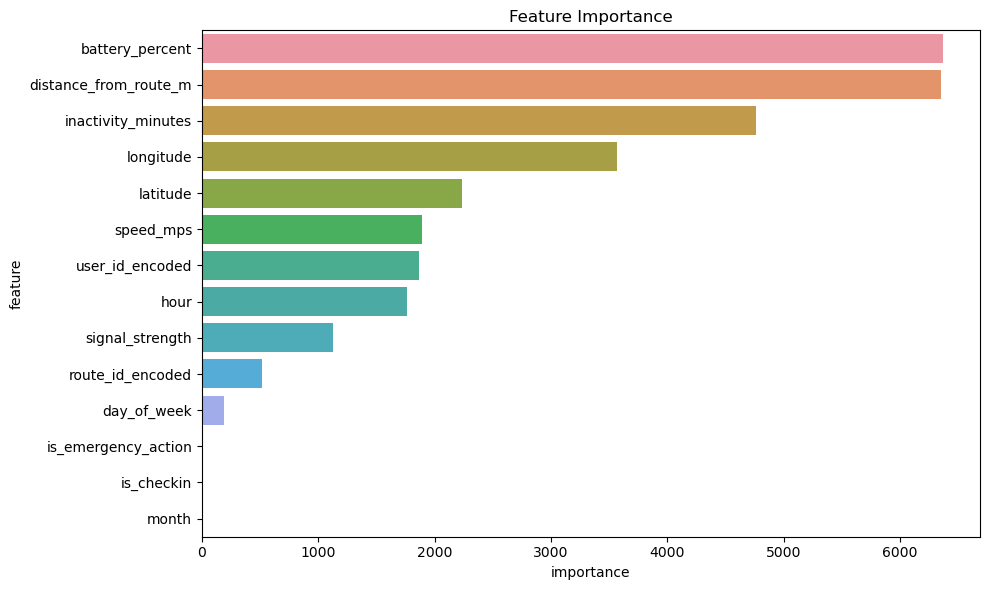

✅ Feature importance saved!


In [10]:
# Feature importance visualization
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Save feature importance
feature_importance.to_csv('../data/feature_importances.csv', index=False)
print("✅ Feature importance saved!")


In [11]:
# Save model
joblib.dump(model, '../data/model_lgbm.pkl')
print("✅ Model saved as model_lgbm.pkl")

# Save feature names for export scripts
import json
with open('../data/feature_names.json', 'w') as f:
    json.dump(feature_cols, f)
print("✅ Feature names saved!")


✅ Model saved as model_lgbm.pkl
✅ Feature names saved!
